## Setup

In [1]:
import os
import sys
import logging
from pathlib import Path

# Add parent directory to path to import celltype_standardizer
sys.path.insert(0, str(Path.cwd().parent))

import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from celltype_standardizer import standardize_h5ad_and_update_mapping, evaluate_h5ad
from celltype_standardizer.standardize import get_label_coverage_report

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Set your OpenAI API key here or via environment variable
# os.environ['OPENAI_API_KEY'] = 'your-api-key-here'

print("Setup complete!")

Setup complete!


In [26]:
# Load API key from config file
import json

config_path = Path('../config/config.json')
if config_path.exists():
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    api_key = config.get('openai', {}).get('api_key')
    
    if api_key and api_key != 'YOUR_OPENAI_API_KEY_HERE':
        os.environ['OPENAI_API_KEY'] = api_key
        print("✓ API key loaded from config.json")
    else:
        print("⚠️  Please set your API key in config/config.json")
        print("   or set it here: os.environ['OPENAI_API_KEY'] = 'your-key'")
else:
    print("⚠️  Config file not found. Set API key manually:")
    print("   os.environ['OPENAI_API_KEY'] = 'your-key'")


✓ API key loaded from config.json


## Load Debug Datasets

In [21]:
# Define paths
data_dir = Path('../../dataset')
gt_file = data_dir / 'datasetGT_debug.h5ad'
test_file = data_dir / 'datasetTest_debug.h5ad'

# Check if files exist
print(f"Ground truth file exists: {gt_file.exists()}")
print(f"Test file exists: {test_file.exists()}")

# Load datasets
if gt_file.exists():
    adata_gt = ad.read_h5ad(gt_file)
    print(f"\nGround truth dataset: {adata_gt.shape[0]} cells")
    print(f"Obs columns: {list(adata_gt.obs.columns)}")
    
if test_file.exists():
    adata_test = ad.read_h5ad(test_file)
    print(f"\nTest dataset: {adata_test.shape[0]} cells")
    print(f"Obs columns: {list(adata_test.obs.columns)}")

Ground truth file exists: True
Test file exists: True



Ground truth dataset: 1000 cells
Obs columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident']

Test dataset: 1000 cells
Obs columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident']


## Workflow 1: Standalone Standardization

First, let's check the coverage of our ground truth labels and then standardize them.

In [22]:
# Inspect available label columns in ground truth
# Adjust the column name based on your actual data
if gt_file.exists():
    print("Available columns in ground truth:")
    print(adata_gt.obs.columns.tolist())
    
    # Check for common cell-type column names
    possible_columns = ['cell_type', 'celltype', 'cell_ontology_class', 'leiden', 'louvain']
    gt_label_column = None
    
    for col in possible_columns:
        if col in adata_gt.obs.columns:
            gt_label_column = col
            print(f"\nUsing column: {gt_label_column}")
            print(f"Unique labels: {adata_gt.obs[col].nunique()}")
            print(f"Sample labels: {adata_gt.obs[col].unique()[:10]}")
            break
    
    if gt_label_column is None:
        print("\nPlease specify the correct column name for cell-type labels")
        gt_label_column = 'cell_type'  # Default fallback

Available columns in ground truth:
['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident']

Using column: celltype
Unique labels: 21
Sample labels: ['CD4+ T cell', 'PIP+ mammary luminal cell', 'Endothelial', 'Tumour-associated macrophage', 'SAA2+ mammary luminal progenitor', 'Macrophage', 'Mammary basal cell', 'Cycling lactocyte', 'Secretoglobin mammary luminal cell', 'Fibroblast']
Categories (21, object): ['B cell', 'CD4+ T cell', 'Cancer-associated fibroblast', 'Cycling lactocyte', ..., 'Secretoglobin mammary luminal cell', 'Tumour-associated macrophage', 'cDC', 'pDC']


In [29]:
# Get label coverage report before standardization
if gt_file.exists() and gt_label_column:
    print("Checking label coverage...\n")
    
    coverage = get_label_coverage_report(
        input_h5ad=gt_file,
        obs_column=gt_label_column
    )
    
    print(f"Total unique labels: {coverage['total_unique_labels']}")
    print(f"Already mapped: {coverage['mapped_count']} ({coverage['coverage_percent']:.1f}%)")
    print(f"Need mapping: {coverage['unmapped_count']}")
    
    if coverage['unmapped_labels']:
        print(f"\nUnmapped labels:")
        for label in coverage['unmapped_labels'][:20]:  # Show first 20
            print(f"  - {label}")

Checking label coverage...

Total unique labels: 21
Already mapped: 21 (100.0%)
Need mapping: 0


In [30]:
# Standardize ground truth labels to L3
# NOTE: This will call the LLM for unmapped labels
# Set skip_llm=True if you want to skip LLM calls for testing

if gt_file.exists() and gt_label_column:
    print("Standardizing ground truth labels...\n")
    
    adata_gt_standardized = standardize_h5ad_and_update_mapping(
        input_h5ad=gt_file,
        obs_column=gt_label_column,
        output_h5ad=data_dir / 'datasetGT_debug_l3.h5ad',
        output_obs_column='cell_type_level3',
        skip_llm=False,  # Set to True to skip LLM calls
    )
    
    print("\nStandardization complete!")
    print(f"L3 labels added to column: 'cell_type_level3'")
    print(f"Unique L3 labels: {adata_gt_standardized.obs['cell_type_level3'].nunique()}")
    print(f"\nL3 label distribution:")
    print(adata_gt_standardized.obs['cell_type_level3'].value_counts())

2025-12-27 18:58:26,291 - celltype_standardizer.standardize - INFO - === Starting standardization workflow ===
2025-12-27 18:58:26,294 - celltype_standardizer.standardize - INFO - Loading AnnData from ../../dataset/datasetGT_debug.h5ad


Standardizing ground truth labels...



2025-12-27 18:58:26,794 - celltype_standardizer.standardize - INFO - Found 21 unique raw labels in column 'celltype'
2025-12-27 18:58:26,806 - celltype_standardizer.standardize - INFO - Mapping store stats: {'total_mappings': 21, 'last_updated': '2025-12-27T18:56:10.117552', 'file_path': '/Users/vincent_c/projects/celltype_eval_llm/mappings/label_mappings.json'}
2025-12-27 18:58:26,823 - celltype_standardizer.standardize - INFO - Found 0 labels without existing mappings
2025-12-27 18:58:26,844 - celltype_standardizer.standardize - INFO - Standardization complete:
2025-12-27 18:58:26,881 - celltype_standardizer.standardize - INFO -   - Standardized to 7 unique L3 labels
2025-12-27 18:58:26,887 - celltype_standardizer.standardize - INFO -   - 0 cells remain unmapped
... storing 'cell_type_level3' as categorical
2025-12-27 18:58:27,981 - celltype_standardizer.standardize - INFO - Saved standardized AnnData to ../../dataset/datasetGT_debug_l3.h5ad
2025-12-27 18:58:27,983 - celltype_standar


Standardization complete!
L3 labels added to column: 'cell_type_level3'
Unique L3 labels: 7

L3 label distribution:
cell_type_level3
Non neoplastic             673
Lymphoid cells             104
Macrophages/Histiocytes     80
Fibroblasts                 72
Leukocytes                  35
Endothelial                 33
Mast cells                   3
Name: count, dtype: int64


## Visualize Ground Truth L3 Distribution

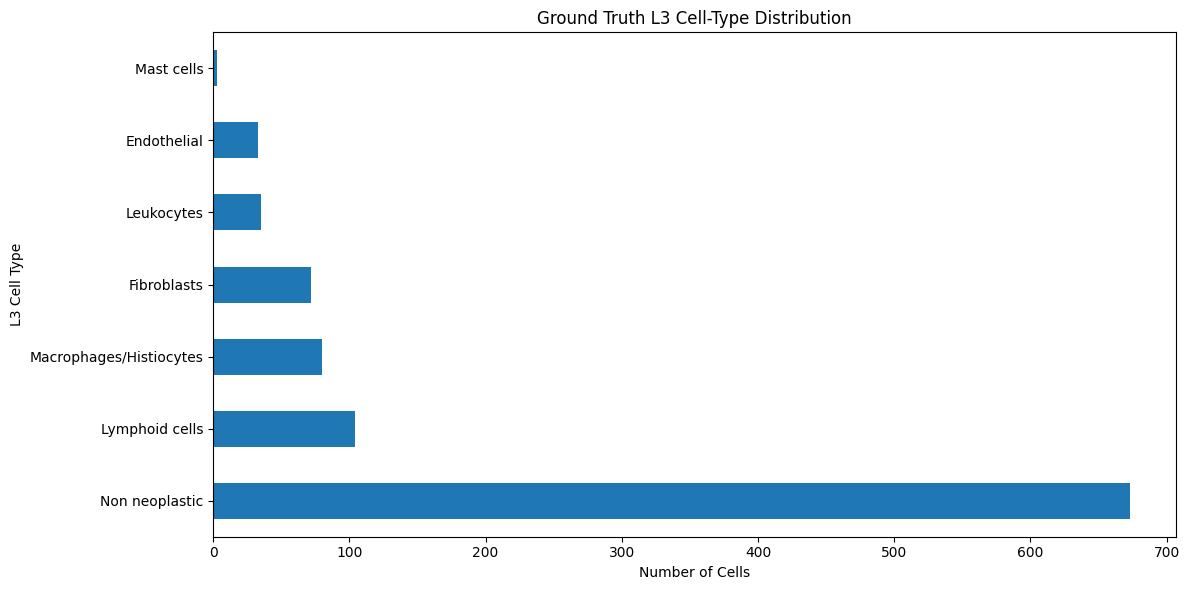

In [31]:
# Plot L3 label distribution
if gt_file.exists() and 'adata_gt_standardized' in locals():
    plt.figure(figsize=(12, 6))
    label_counts = adata_gt_standardized.obs['cell_type_level3'].value_counts()
    
    ax = label_counts.plot(kind='barh')
    plt.xlabel('Number of Cells')
    plt.ylabel('L3 Cell Type')
    plt.title('Ground Truth L3 Cell-Type Distribution')
    plt.tight_layout()
    plt.show()

## Workflow 2: Evaluation

Now let's evaluate predictions from the test dataset against the ground truth.

In [ ]:
# Identify prediction and ground truth columns in test dataset
if test_file.exists():
    print("Available columns in test dataset:")
    print(adata_test.obs.columns.tolist())
    
    # You'll need to specify which columns contain predictions and ground truth
    # This is dataset-specific
    test_pred_column = None
    test_gt_column = None
    
    # Common patterns
    pred_candidates = ['predicted', 'prediction', 'pred_cell_type', 'predicted_type']
    gt_candidates = ['cell_type', 'celltype', 'true_type', 'ground_truth']
    
    for col in pred_candidates:
        if col in adata_test.obs.columns:
            test_pred_column = col
            break
    
    for col in gt_candidates:
        if col in adata_test.obs.columns:
            test_gt_column = col
            break
    
    print(f"\nPrediction column: {test_pred_column}")
    print(f"Ground truth column: {test_gt_column}")
    
    if test_pred_column is None or test_gt_column is None:
        print("\n⚠️ Please manually specify the correct column names below:")
        # Set these manually based on your data
        # test_pred_column = 'your_prediction_column'
        # test_gt_column = 'your_ground_truth_column'

In [ ]:
# Run evaluation
if test_file.exists() and test_pred_column and test_gt_column:
    print("Running evaluation...\n")
    
    metrics = evaluate_h5ad(
        pred_h5ad=test_file,
        pred_column=test_pred_column,
        gt_h5ad=None,  # Ground truth is in the same file
        gt_column=test_gt_column,
        metrics_output_path=data_dir / 'evaluation_metrics.json',
        skip_llm=False,  # Set to True to skip LLM calls
    )
    
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  Macro F1:    {metrics['macro_f1']:.4f}")
    print(f"  Weighted F1: {metrics['weighted_f1']:.4f}")
    print(f"\nDataset Info:")
    print(f"  Total cells: {metrics['dataset_info']['total_cells']}")
    print(f"  Unique L3 labels (pred): {metrics['dataset_info']['standardized_pred_labels']}")
    print(f"  Unique L3 labels (GT):   {metrics['dataset_info']['standardized_gt_labels']}")

## Visualize Evaluation Results

In [ ]:
# Plot per-class metrics
if 'metrics' in locals():
    per_class = pd.DataFrame(metrics['per_class_metrics']).T
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    per_class['precision'].plot(kind='barh', ax=axes[0], color='skyblue')
    axes[0].set_title('Precision by L3 Cell Type')
    axes[0].set_xlabel('Precision')
    axes[0].set_xlim([0, 1])
    
    per_class['recall'].plot(kind='barh', ax=axes[1], color='lightcoral')
    axes[1].set_title('Recall by L3 Cell Type')
    axes[1].set_xlabel('Recall')
    axes[1].set_xlim([0, 1])
    
    per_class['f1_score'].plot(kind='barh', ax=axes[2], color='lightgreen')
    axes[2].set_title('F1 Score by L3 Cell Type')
    axes[2].set_xlabel('F1 Score')
    axes[2].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot confusion matrix
if 'metrics' in locals():
    import numpy as np
    
    cm_data = metrics['confusion_matrix']
    cm_matrix = np.array(cm_data['matrix'])
    labels = cm_data['labels']
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Count'}
    )
    plt.title('Confusion Matrix (L3 Labels)', fontsize=14, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Inspect Mapping Store

Let's see what mappings have been learned.

In [ ]:
from celltype_standardizer.mapping_store import MappingStore

# Load mapping store
store = MappingStore()
mappings = store.get_all_mappings()
stats = store.get_stats()

print("Mapping Store Statistics:")
print(f"  Total mappings: {stats['total_mappings']}")
print(f"  Last updated: {stats['last_updated']}")
print(f"  File: {stats['file_path']}")

print(f"\nSample mappings (first 20):")
for i, (raw, l3) in enumerate(list(mappings.items())[:20]):
    print(f"  {raw:30s} -> {l3}")

## Summary

This notebook demonstrated:

1. **Workflow 1**: Standalone standardization
   - Check label coverage
   - Standardize raw labels to L3 using LLM semantic matching
   - Update persistent mapping store
   - Save standardized dataset

2. **Workflow 2**: Evaluation
   - Load predictions and ground truth
   - Standardize both to L3 (reusing existing mappings when possible)
   - Compute evaluation metrics (accuracy, F1, confusion matrix)
   - Visualize results

3. **Mapping Store**: Persistent storage that grows over time
   - Mappings are reused across runs
   - LLM is only called for new, unmapped labels
   - Thread-safe with file locking